## Simulation showing Advantage of Duobinary Signaling over Rectangular Pulse

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.fftpack
from scipy import signal

%matplotlib inline

### Helper functions

In [9]:
# Create rectangular pulse
def rect(t, duty=0.5, Rb=1, delay=0):
    pt = np.where(abs(t-delay/Rb)<=duty/(2*Rb), 1, 0)
    return pt

# Create duobinary pulse
def duob(t, Rb=1, delay=0):
    pt = np.sinc(t*Rb-delay) + np.sinc(t*Rb-delay-1)
    return pt

# Resample the signal
def resamp(pt, t1, t2, psamp, nsamp, centre=False):
    d = (t2-t1)/(psamp-1)
    offset = (0.5 if centre else 0)
    return [(int((i+offset)/(nsamp*d)), pt[int((i+offset)/(nsamp*d))]) for i in range(int(nsamp*(t2-t1)))]

# Simulate a noisy bandlimited channel
def channel(mean, std, cutoff, sig, samp_spc, samp_n):
    noise = np.random.normal(mean, std, size=samp_n) # Gaussian noise
    w = cutoff*2*samp_spc # Normalize the frequency
    b, a = signal.butter(5, w, 'low') # Low pass filter
    return signal.filtfilt(b, a, sig) + noise

# Encode the byte string given to it into bit string
def enc(msg=b"Hey there!"):
    msgb = list()
    for i in msg:
        for j in '{:08b}'.format(i):
            msgb.append(int(j))
    return msgb

# Decode the bit string given to it into character string
def dec(msgb):
    rcv = ''
    temp = 0
    for i in range(len(msgb)):
        temp += msgb[i]*2**(7 - i%8)
        if i%8==7:
            rcv += chr(temp)
            temp = 0
    return rcv

# Differential encoding of input signal
def diff_enc(msgb):
    p = [0]
    for i in msgb:
        p.append(i^p[-1])
    return p[1:]

### Duobinary & Rectangular pulse and their output after passing through noisy bandlimited channel

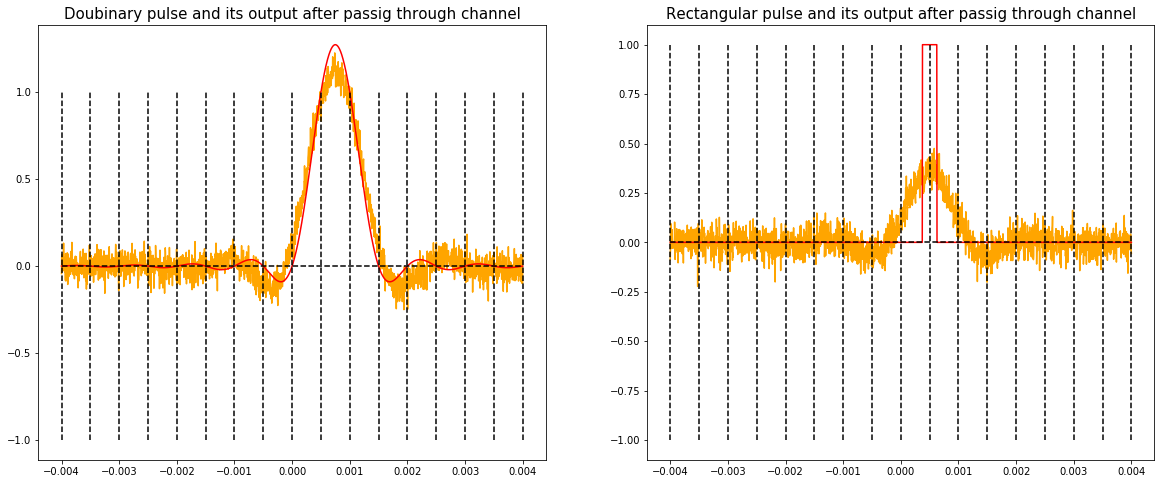

In [10]:
B = 1000 # Bandwidth of channel
Rb = 2*B # Sampling frequency or data transfer rate
Ts = 1/Rb
t1, t2, N = -4/B, 4/B, Rb+1 # Time interval and number of samples
d = (t2-t1)/(N-1) # Sample spacing

fc = 700  # Cut-off frequency of the filter
mean, std = 0, 0.05 # Mean and standard deviation of gaussian noise

t = np.linspace(t1, t2, int(N)) # Time variable

duo_pt = duob(t, Rb=Rb, delay=1) # Duobinary pulse delayed in time domain by one sample
duo_out = channel(mean, std, fc, duo_pt, d, N) # Output signal after passing through noisy bandlimited channel

rect_pt = rect(t, duty=0.5, Rb=Rb, delay=1) # Rectangular pulse delayed in time domain by one sample
rect_out = channel(mean, std, fc, rect_pt, d, N) # Output signal after passing through noisy bandlimited channel

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plot Duobinary pulse & its output
ax[0].plot(t, duo_out, color='orange') #Shown in orange colour
ax[0].plot(t, duo_pt, color='red') # Shown in red line
ax[0].set_title("Doubinary pulse and its output after passig through channel", fontsize=15)

# Plot horizontal and vertical lines to show the marks
ax[0].plot(np.linspace(t1, t2, 100), [0]*100, color='black', linestyle='dashed')
for i in np.linspace(t1, t2, int((t2-t1)*Rb)+1):
    ax[0].plot([i]*100, np.linspace(-1, 1, 100), color='black', linestyle='dashed')


# Plot Rectangular pulse & its output
ax[1].plot(t, rect_out, color='orange') #Shown in orange colour
ax[1].plot(t, rect_pt, color='red') # Shown in red line
ax[1].set_title("Rectangular pulse and its output after passig through channel", fontsize=15)

# Plot horizontal and vertical lines to show the marks
ax[1].plot(np.linspace(t1, t2, 100), [0]*100, color='black', linestyle='dashed')
for i in np.linspace(t1, t2, int((t2-t1)*Rb)+1):
    ax[1].plot([i]*100, np.linspace(-1, 1, 100), color='black', linestyle='dashed')

###### As we can see above, duobinary pulse is very less distorted compared to Rectangular pulse, after passing through channel.

### Simulating the channel effect on Duobinary & Rectangul signal by transmitting some message using them

In [11]:
msg = b"Hey there! Do you know NMG is God." # Input string message
msgb = enc(msg=msg) # Convert message into bit string
msg_diff = np.array(diff_enc(msgb)) # Differential encoding
msgp = 2*msg_diff - 1 # Convert into polar code

In [12]:
B = 1000 # Bandwidth of channel
Rb = 2*B # Sampling frequency or data transfer rate
Ts = 1/Rb

''' Since transmitted signal is time-limited, on passing it through a band-limited channel
it gets distorted a lot, mainly at the ends. So I'm padding the transmitted signal at both ends'''
padding = 10

t1, t2, N = 0, (len(msgp)+padding)*Ts, 2*B+1 # Time interval and number of samples
d = (t2-t1)/(N-1) # Sample spacing

fc = 750  # Cut-off frequency of the filter
mean, std = 0, 0.01 # Mean and standard deviation of gaussian noise

tx_t = np.linspace(t1, t2, int(N)) # Time variable

###### For Doubinary signal

Message is received and decoded with accuracy: 1.0
Received message:-
Hey there! Do you know NMG is God.


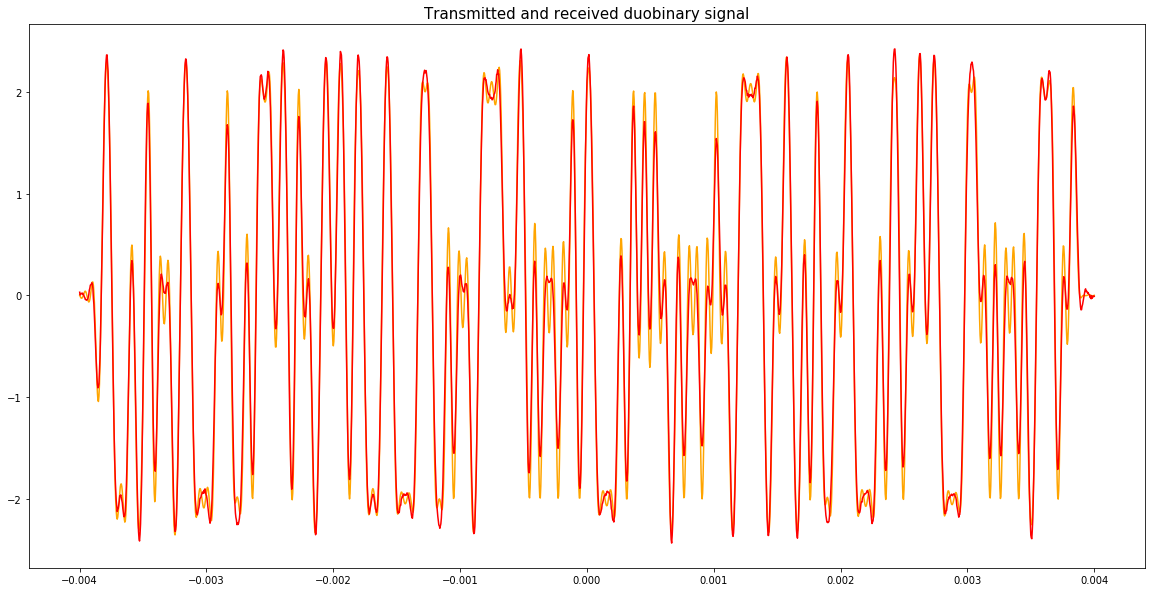

In [13]:
# Creating the duobiary signal from pulse to carry bit string
tx_duo = np.zeros(int(N))
pulse_duo = list()
for i in range(len(msgp)):
    pulse_duo.append(msgp[i]*duob(tx_t, Rb=Rb, delay=i+padding//2))
    ''' Uncomment below line to see the individual pulses carrying one bit
        and controled interference between neighbouring pulses'''
    # plt.plot(tx_t, pulse_duo[-1])
    tx_duo += pulse_duo[-1]

rx_duo = channel(mean, std, fc, tx_duo, d, N) # Received signal after passing through channel
samp_duo = resamp(rx_duo, t1, t2, N, Rb) # Samples of received signal

bit_duo = list()
# Decision algorithm to get bit string from received samples
for i in samp_duo:
    if np.abs(i[1])<0.7:
        bit_duo.append(1)
    else:
        bit_duo.append(0)
bit_duo = bit_duo[padding//2:len(msgb)+padding//2] # Bit string after removing padding

acc_duo = np.mean(np.array(bit_duo)==np.array(msgb)) # Accuracy calculation
msg_duo = dec(bit_duo) # Decoding character string into bit string

# Plot Duobinary pulse & its output
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.plot(t, tx_duo, color='orange') # Transmitted signal shown in orange colour
ax.plot(t, rx_duo, color='red') # Received signal shown in red line
ax.set_title("Transmitted and received duobinary signal", fontsize=15)

print(f"Message is received and decoded with accuracy: {acc_duo}")
print(f"Received message:-\n{msg_duo}")

###### We can see above how well doubinary signal cope up with the effects of channel

###### For Rectangular signal

Message is received and decoded with accuracy: 0.4522058823529412
Received message:-
ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿ


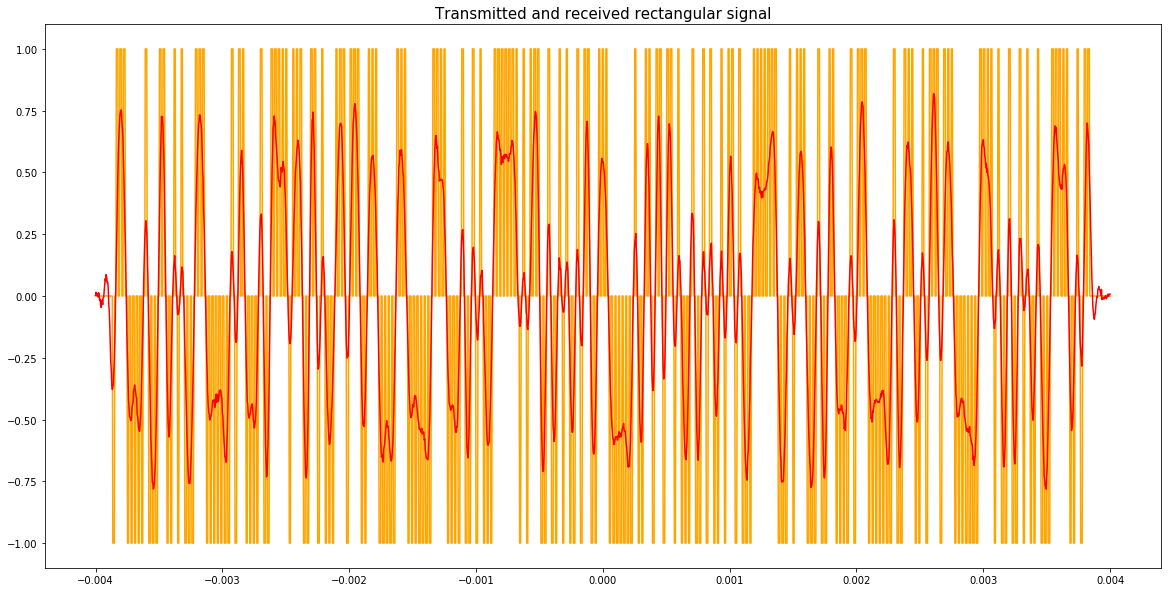

In [14]:
# Creating the rectangular signal from pulse to carry bit string
tx_rect = np.zeros(int(N))
pulse_rect = list()
for i in range(len(msgp)):
    pulse_rect.append(msgp[i]*rect(tx_t, Rb=Rb, delay=i+padding//2))
    # Uncomment below line to see the individual pulses carrying one bit
    # plt.plot(tx_t, pulse_rect[-1])
    tx_rect += pulse_rect[-1]

rx_rect = channel(mean, std, fc, tx_rect, d, N) # Received signal after passing through channel
samp_rect = resamp(rx_rect, t1, t2, N, Rb) # Samples of received signal

bit_rect = list()
# Decision algorithm to get bit string from received samples
for i in samp_rect:
    if np.abs(i[1])>0:
        bit_rect.append(1)
    else:
        bit_rect.append(0)
bit_rect = bit_rect[padding//2:len(msgb)+padding//2] # Bit string after removing padding

acc_rect = np.mean(np.array(bit_rect)==np.array(msgb)) # Accuracy calculation
msg_rect = dec(bit_rect) # Decoding character string into bit string

# Plot transmitted & received signal
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.plot(t, tx_rect, color='orange') # Transmitted signal shown in orange line
ax.plot(t, rx_rect, color='red') # Received signal shown in red colour
ax.set_title("Transmitted and received rectangular signal", fontsize=15)

print(f"Message is received and decoded with accuracy: {acc_rect}")
print(f"Received message:-\n{msg_rect}")

###### As we can see above, Rectangular signaling performs very poorly compared to duobinary signaling